In [1]:
import os
import time
from lib.data_parser import DataParser
from lib.data_manager import DataManager
from lib.util import load_file
from lib.util import build_tweet_graph, draw_tweet_network

# Schema Preview

In [4]:
import json
from pprint import pprint

# Tweet thread
with open('pheme-raw/threads/en/ebola-essien/521346721226711040/annotation.json', 'r') as file:
    data = json.load(file)
pprint(data)

{'category': 'Michael Essien has contracted the Ebola virus',
 'is_rumour': 'rumour',
 'is_turnaround': 0,
 'links': [{'link': 'http://bleacherreport.com/articles/2229044-ghana-and-ac-milan-star-michael-essien-denies-rumours-his-has-ebola-virus? '
                    'utm_source=twitter.com',
            'mediatype': 'other-media',
            'position': 'against'},
           {'link': 'https://instagram.com/p/uEGy17hvGG/',
            'mediatype': 'social-media',
            'position': 'against'},
           {'link': 'http://dailypost.ng/2014/10/12/truth-internet-rumours-michael-essien-denies-contracted-ebola/',
            'mediatype': 'news-media',
            'position': 'against'},
           {'link': 'http://www.dailystar.co.uk/news/latest-news/404751/Former-Chelsea-star-Michael-Essien-forced-deny-fake-reports-claiming-he-has-Ebola',
            'mediatype': 'news-media',
            'position': 'against'}],
 'misinformation': '1'}


In [2]:
# Source tweet
with open('pheme-raw/threads/en/sydneysiege/544293753130082305/source-tweets/544293753130082305.json', 'r') as file:
    data = json.load(file)
pprint(data)

{'contributors': None,
 'coordinates': None,
 'created_at': 'Mon Dec 15 00:51:57 +0000 2014',
 'entities': {'hashtags': [{'indices': [54, 61], 'text': 'Sydney'}],
              'media': [{'display_url': 'pic.twitter.com/7u8EFUwCey',
                         'expanded_url': 'http://twitter.com/RT_com/status/544293753130082305/photo/1',
                         'id': 544293512523415553,
                         'id_str': '544293512523415553',
                         'indices': [92, 114],
                         'media_url': 'http://pbs.twimg.com/media/B424ENuCAAEeGNS.png',
                         'media_url_https': 'https://pbs.twimg.com/media/B424ENuCAAEeGNS.png',
                         'sizes': {'large': {'h': 819,
                                             'resize': 'fit',
                                             'w': 491},
                                   'medium': {'h': 819,
                                              'resize': 'fit',
                                 

In [3]:
# Retweet
with open('pheme-raw/threads/en/sydneysiege/544293753130082305/retweets.json', 'r') as file:
    data = json.load(file)
pprint(data)

[{'contributors': None,
  'coordinates': None,
  'created_at': 'Mon Dec 15 13:15:57 +0000 2014',
  'entities': {'hashtags': [{'indices': [66, 73], 'text': 'Sydney'}],
               'media': [{'display_url': 'pic.twitter.com/7u8EFUwCey',
                          'expanded_url': 'http://twitter.com/RT_com/status/544293753130082305/photo/1',
                          'id': 544293512523415553,
                          'id_str': '544293512523415553',
                          'indices': [104, 126],
                          'media_url': 'http://pbs.twimg.com/media/B424ENuCAAEeGNS.png',
                          'media_url_https': 'https://pbs.twimg.com/media/B424ENuCAAEeGNS.png',
                          'sizes': {'large': {'h': 819,
                                              'resize': 'fit',
                                              'w': 491},
                                    'medium': {'h': 819,
                                               'resize': 'fit',
                

# Preprocessing

In [3]:
def process_event_threads(base_path: str, event_name: str, data_manager: DataManager, parser: DataParser, combined_followers_file):
    """Processes all threads for a specific event."""
    
    thread_count = 0
    for thread_id in os.listdir(f"{base_path}/{event_name}"):
        thread_count += 1

        parser.add_thread_annotation(f"{base_path}/{event_name}/{thread_id}/annotation.json", thread_id)

        # Process source tweets
        source_tweet_dir = f"{base_path}/{event_name}/{thread_id}/source-tweets"
        for source_tweet_file in os.listdir(source_tweet_dir):
            source_tweet = load_file(f"{source_tweet_dir}/{source_tweet_file}")
            new_tweet = parser.parse_tweet(source_tweet, thread_id, event_name)
            data_manager.add_data(new_tweet)

        # Process reactions
        reaction_dir = f"{base_path}/{event_name}/{thread_id}/reactions"
        for reaction_file in os.listdir(reaction_dir):
            reaction_tweet = load_file(f"{reaction_dir}/{reaction_file}")
            new_reaction = parser.parse_tweet(reaction_tweet, thread_id, event_name)
            data_manager.add_data(new_reaction)

        # Process retweets
        retweets_file_path = f"{base_path}/{event_name}/{thread_id}/retweets.json"
        if os.path.exists(retweets_file_path):
            retweets = load_file(retweets_file_path)
            if not isinstance(retweets, list):
                print(f"Error: {base_path}/{event_name}/{thread_id}/retweets.json")
                print(f"Error: {retweets}")
            for retweet in retweets:
                new_retweet = parser.parse_tweet(retweet, thread_id, event_name)
                data_manager.add_data(new_retweet)

        # Combine follower data
        followers_file_path = f"{base_path}/{event_name}/{thread_id}/who-follows-whom.dat"
        if os.path.exists(followers_file_path):
            with open(followers_file_path, 'r') as followers_file:
                for line in followers_file:
                    combined_followers_file.write(line)

    return thread_count

In [4]:
def preprocess_events(event_names):
    start_time = time.time()
    base_path = "pheme-raw/threads/en"
    data_manager = DataManager()
    parser = DataParser("pheme-raw/annotations/en-scheme-annotations.json")

    thread_count = 0
    combined_followers_file_path = "data/who-follows-whom.dat"

    with open(combined_followers_file_path, 'w') as combined_followers_file:
        for event_name in event_names:
            processed_threads = process_event_threads(base_path, event_name, data_manager, parser, combined_followers_file)
            thread_count += processed_threads

    print(f"{thread_count} threads were processed for event(s): {', '.join(event_names)}")
    print(f"Data processed in {(time.time() - start_time) / 60:.2f} minutes")

    return data_manager

## All events

In [9]:
event_names = [
    "charliehebdo",
    "ebola-essien",
    "ferguson",
    "germanwings-crash",
    "ottawashooting",
    "prince-toronto",
    "putinmissing",
    "sydneysiege"
]

data_manager = preprocess_events(event_names)

Number of annotations: 4560
297 threads were processed for event(s): charliehebdo, ebola-essien, ferguson, germanwings-crash, ottawashooting, prince-toronto, putinmissing, sydneysiege
Data processed in 0.71 minutes


In [10]:
file_path = 'data/tweets/tweets-data.csv'
data_manager.save_to_csv(file_path)
print(f"Tweet data has been saved to {file_path}.")

Tweet data has been saved to data/tweets/tweets-data.csv.


In [12]:
tweets_df = data_manager.get_tweets_df()
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65853 entries, 0 to 65852
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   thread_id                 65853 non-null  int64 
 1   tweet_id                  65853 non-null  int64 
 2   user_id                   65853 non-null  int64 
 3   event                     65853 non-null  object
 4   tweet_class               65853 non-null  object
 5   in_reply_to_status_id     65853 non-null  int64 
 6   in_reply_to_user_id       65853 non-null  int64 
 7   support                   297 non-null    object
 8   responsetype_vs_source    4263 non-null   object
 9   responsetype_vs_previous  1654 non-null   object
 10  favorite_count            65853 non-null  int64 
 11  retweet_count             65853 non-null  int64 
 12  created_at                65853 non-null  object
 13  place                     263 non-null    object
dtypes: int64(7), object(7)

## Ebola-essien event

In [5]:
event_names = ['ebola-essien']
data_manager = preprocess_events(event_names)

Number of annotations: 4560
2 threads were processed for event(s): ebola-essien
Data processed in 0.00 minutes


In [6]:
file_name = 'data/tweets/ebola-essien.csv'
data_manager.save_to_csv(file_name)
print(f"Tweet data has been saved to {file_name}.")

Tweet data has been saved to data/tweets/ebola-essien.csv.


In [ ]:
data_manager = DataManager()
# tweets_df = data_manager.get_event_tweets_df("ebola-essien")
tweets_df = data_manager.load_csv('ebola-essien.csv')
tweets_df.info()

AttributeError: 'DataManager' object has no attribute '__load_csv'

In [5]:
tweets_df.head()

,thread_id,tweet_id,user_id,event,tweet_class,in_reply_to_status_id,in_reply_to_user_id,support,responsetype_vs_source,responsetype_vs_previous,favorite_count,retweet_count,created_at,place
0,521346721226711040,521346721226711040,579635019,ebola-essien,source,0,0,supporting,NaN,NaN,85,575,Sun Oct 12 17:08:39 +0000 2014,NaN
1,521346721226711040,521349366037356544,463260500,ebola-essien,direct reply,521346721226711040,579635019,NaN,appeal-for-more-information,NaN,5,1,Sun Oct 12 17:19:09 +0000 2014,NaN
2,521346721226711040,521349434719076352,430026970,ebola-essien,direct reply,521346721226711040,579635019,NaN,comment,NaN,1,1,Sun Oct 12 17:19:26 +0000 2014,NaN
3,521346721226711040,521350130851921921,379856833,ebola-essien,direct reply,521346721226711040,579635019,NaN,comment,NaN,0,0,Sun Oct 12 17:22:12 +0000 2014,"{'full_name': 'Brasília, Distrito Federal', 'u..."
4,521346721226711040,521350466647891968,458672503,ebola-essien,direct reply,521346721226711040,579635019,NaN,comment,NaN,1,0,Sun Oct 12 17:23:32 +0000 2014,NaN


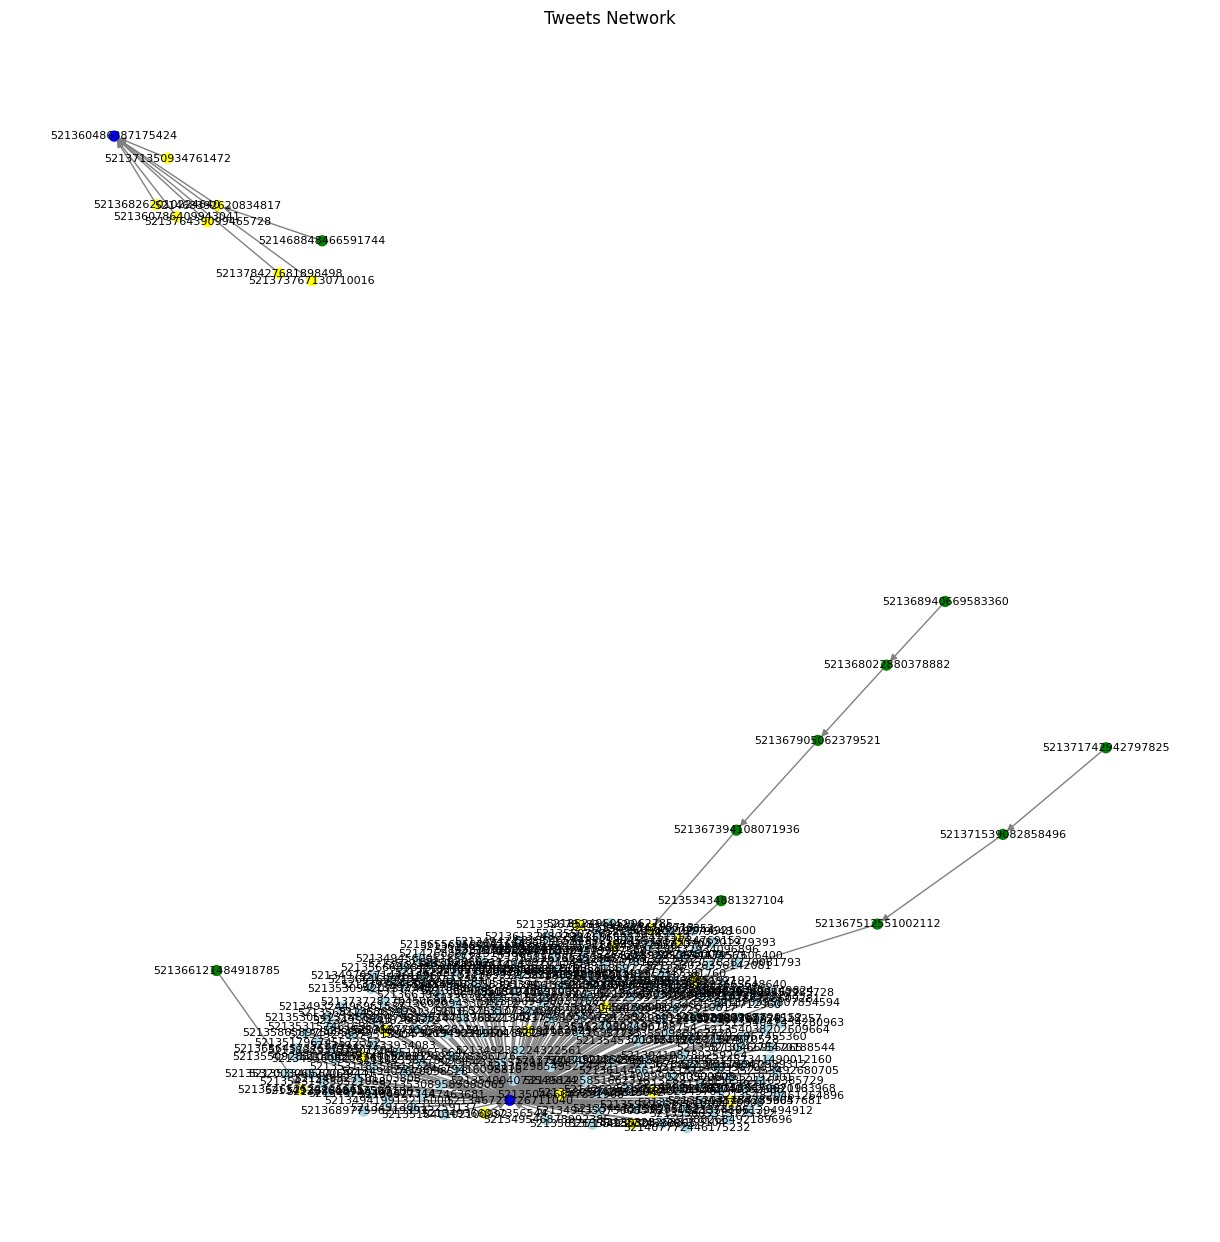

In [6]:
tweet_graph = build_tweet_graph(tweets_df)
draw_tweet_network(tweet_graph)